In [1]:
# =========================
# Padding 32 – Auditoría y Visualización Interactiva
# Aplica padding simétrico para ajustar dimensiones a múltiplos de 32 en un volumen aleatorio del ATM'22.
# Proporciona un log de auditoría completo y una visualización interactiva 3-en-1.
# =========================

import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# === 1. Configuración ===
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr",
    # "images_batch2": r"./TrainBatch2/imagesTr",  # Comentado: no está disponible
    # "labels_batch2": r"./TrainBatch2/labelsTr"   # Comentado: no está disponible
}

# Parámetros de Padding
PADDING_MULTIPLE = 32
PADDING_VALUE = -1024  # HU de aire

# === 2. Selección aleatoria de un caso ===
batch_key = "batch1"
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

selected_image = random.choice(image_files)
case_id = selected_image.replace("_0000.nii.gz", "")

label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === 3. Carga y procesamiento ===
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# Aplica HU Clipping (precondición para el padding)
HU_MIN, HU_MAX = -1024, 600
vol_clipped = np.clip(vol_orig, HU_MIN, HU_MAX)

# === Aplica Padding a Múltiplos de 32 (LÓGICA IDÉNTICA A CELL 2) ===
def pad_to_multiple_identical(volume, multiple, pad_value):
    """Aplica padding simétrico, replicando EXACTAMENTE la lógica de Cell 2."""
    pad_width = []
    for dim in volume.shape:
        remainder = dim % multiple
        if remainder == 0:
            pad_before, pad_after = 0, 0
        else:
            pad_total = multiple - remainder
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
        pad_width.append((pad_before, pad_after))
    
    padded_vol = np.pad(volume, pad_width, mode='constant', constant_values=pad_value)
    return padded_vol, pad_width

vol_padded, pad_width = pad_to_multiple_identical(vol_clipped, PADDING_MULTIPLE, PADDING_VALUE)

# === 4. Generación del Log de Auditoría ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión Original (Clipped)": vol_clipped.shape,
    "Dimensión Padded": vol_padded.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "Valor de Padding": PADDING_VALUE,
    "Ancho de Padding (Z, Y, X)": pad_width
}

print("=" * 50)
print("       LOG DE AUDITORÍA: PADDING 32")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === 5. Visualización Interactiva ===
def visualize_axial_slice(slice_idx):
    """
    Muestra un corte axial con la imagen clipped, la imagen con padding y la máscara de label.
    """
    padded_slice_idx = slice_idx + pad_width[1][0]

    clipped_slice = np.rot90(vol_clipped[:, slice_idx, :], k=1) if slice_idx < vol_clipped.shape[1] else np.zeros_like(vol_clipped[:, 0, :])
    padded_slice = np.rot90(vol_padded[:, padded_slice_idx, :], k=1)
    label_slice = np.rot90(vol_label[:, slice_idx, :], k=1) if slice_idx < vol_label.shape[1] else np.zeros_like(vol_label[:, 0, :])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Caso: {case_id}  | Corte Axial Y={slice_idx} (Clipped) / Y={padded_slice_idx} (Padded)", fontsize=12, weight='bold')

    axes[0].imshow(clipped_slice, cmap="gray", vmin=-1024, vmax=600)
    axes[0].set_title("TC con HU Clipping", fontsize=12)
    axes[0].axis("off")

    axes[1].imshow(padded_slice, cmap="gray", vmin=-1024, vmax=600)
    axes[1].set_title("TC con Padding 32", fontsize=12)
    axes[1].axis("off")

    axes[2].imshow(label_slice, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
    axes[2].set_title("Segmentación Manual (Label)", fontsize=12)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

default_slice = vol_clipped.shape[1] // 2

interact(
    visualize_axial_slice,
    slice_idx=IntSlider(
        value=default_slice,
        min=0,
        max=vol_clipped.shape[1] - 1,
        step=1,
        description="Corte Y (Clipped):",
        continuous_update=False,
        style={'description_width': 'initial'}
    )
);

       LOG DE AUDITORÍA: PADDING 32
Caso Analizado           : ATM_100
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_100_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_100_0000.nii.gz
Dimensión Original (Clipped): (512, 512, 799)
Dimensión Padded         : (512, 512, 800)
Espaciado (mm)           : (np.float32(0.781), np.float32(0.781), np.float32(0.5))
Valor de Padding         : -1024
Ancho de Padding (Z, Y, X): [(0, 0), (0, 0), (0, 1)]


interactive(children=(IntSlider(value=256, continuous_update=False, description='Corte Y (Clipped):', max=511,…

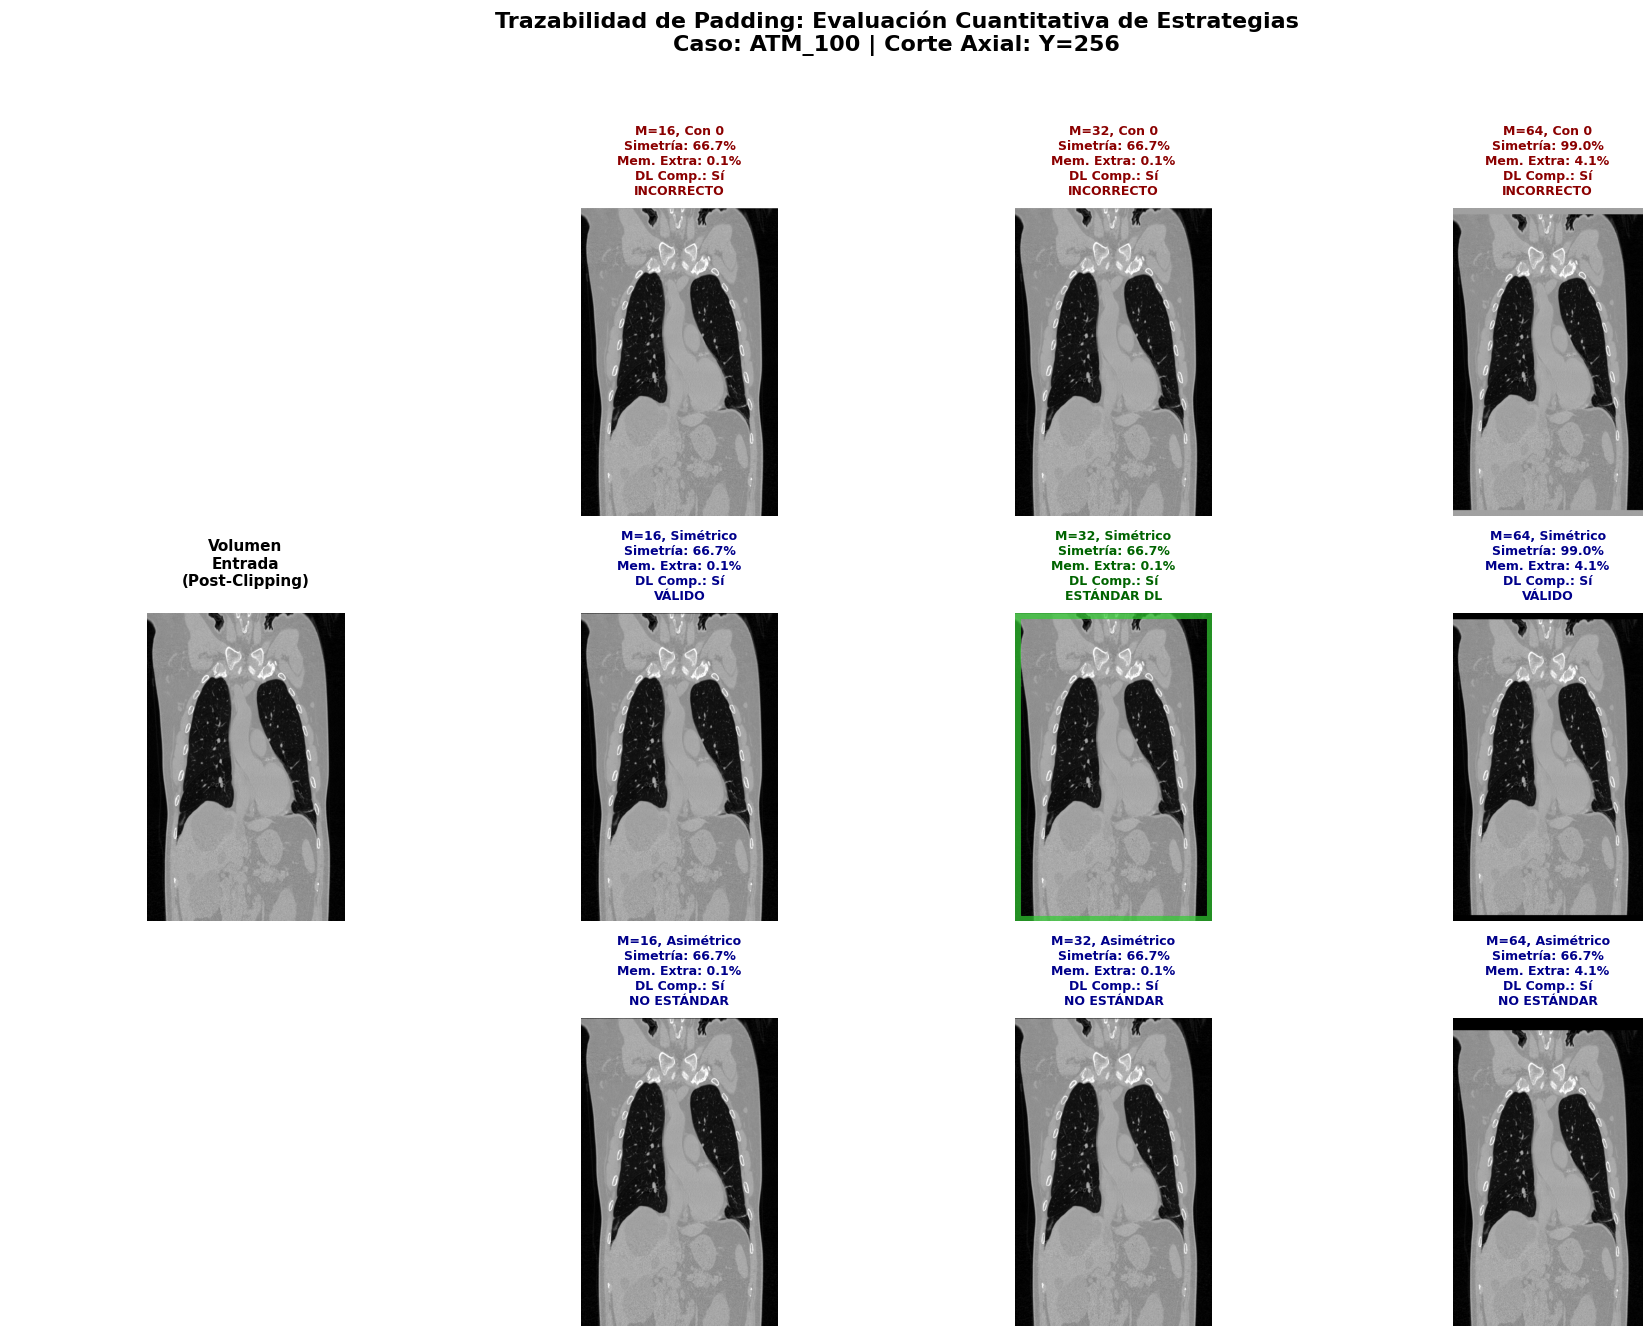


Escenario Óptimo de Padding: Múltiplo=32, Simétrico, Valor=Aire (-1024)
- Dimensiones Finales: (512, 512, 800)
- Simetría del Padding: 66.7%
- Uso de Memoria Adicional: 0.1%
- Compatibilidad DL (múltiplo de 32): Sí


In [2]:
# =========================
# Trazabilidad de Padding – Mosaico Comparativo con Métricas Cuantitativas
# Visualización del impacto de diferentes estrategias y múltiplos de padding,
# enriquecida con métricas técnicas de simetría y eficiencia de memoria.
# =========================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Seleccionar un corte central representativo ===
slice_idx = vol_clipped.shape[1] // 2
clipped_slice = np.rot90(vol_clipped[:, slice_idx, :], k=1)

# === 2. Función para calcular métricas cuantitativas del padding ===
def calculate_padding_metrics(padded_vol, orig_vol, pad_width):
    """
    Calcula métricas técnicas clave para evaluar una operación de padding.
    """
    # 1. Simetría del Padding (%)
    symmetry_scores = []
    for (before, after) in pad_width:
        if before + after == 0:
            symmetry_scores.append(1.0)
        else:
            symmetry = 1.0 - (abs(before - after) / (before + after))
            symmetry_scores.append(symmetry)
    avg_symmetry = np.mean(symmetry_scores) * 100
    
    # 2. Uso de Memoria Adicional (%)
    orig_size = np.prod(orig_vol.shape)
    padded_size = np.prod(padded_vol.shape)
    memory_overhead = ((padded_size - orig_size) / orig_size) * 100
    
    # 3. Compatibilidad con Deep Learning (¿Es múltiplo de 32?)
    # Esta es una métrica binaria de relevancia para el pipeline DL.
    is_compatible = all(dim % 32 == 0 for dim in padded_vol.shape)
    
    return avg_symmetry, memory_overhead, is_compatible

# === 3. Definir escenarios de prueba (9 combinaciones) ===
test_scenarios = [
    # Fila 1: Padding con valor 0 (incorrecto para CT)
    (16, 'constant', 0), (32, 'constant', 0), (64, 'constant', 0),
    # Fila 2: Padding simétrico con valor de aire (-1024) -> Nuestro enfoque
    (16, 'constant', -1024), (32, 'constant', -1024), (64, 'constant', -1024),
    # Fila 3: Padding asimétrico (solo al final) con valor de aire
    (16, 'edge', -1024), (32, 'edge', -1024), (64, 'edge', -1024),
]

# === Función auxiliar para aplicar padding ===
def apply_padding(volume, multiple, mode, value):
    new_shape = []
    for dim in volume.shape:
        remainder = dim % multiple
        if remainder == 0:
            new_shape.append(dim)
        else:
            new_shape.append(dim + (multiple - remainder))
    
    if mode == 'constant':
        pad_width = []
        for i, dim in enumerate(volume.shape):
            total_pad = new_shape[i] - dim
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_width.append((pad_before, pad_after))
        padded = np.pad(volume, pad_width, mode=mode, constant_values=value)
    else: # 'edge' or others (asymmetric)
        pad_width = []
        for i, dim in enumerate(volume.shape):
            total_pad = new_shape[i] - dim
            pad_width.append((0, total_pad))
        padded = np.pad(volume, pad_width, mode='constant', constant_values=value)
    
    return padded, pad_width

# Pre-calcular todas las métricas
all_metrics = []
padded_volumes = []
pad_widths_list = []

for multiple, mode, value in test_scenarios:
    padded_vol, pad_width = apply_padding(vol_clipped, multiple, mode, value)
    metrics = calculate_padding_metrics(padded_vol, vol_clipped, pad_width)
    padded_volumes.append(padded_vol)
    pad_widths_list.append(pad_width)
    all_metrics.append(metrics)

# === 4. Crear el mosaico de 3x4 con métricas integradas ===
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
fig.suptitle(
    f'Trazabilidad de Padding: Evaluación Cuantitativa de Estrategias\n'
    f'Caso: {case_id} | Corte Axial: Y={slice_idx}',
    fontsize=16, weight='bold', y=0.98
)

plt.rcParams.update({'font.size': 9})
for ax in axes.flat:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --- Columna 1: Volumen Original ---
axes[0, 0].axis('off')
axes[2, 0].axis('off')
ax_orig = axes[1, 0]
ax_orig.imshow(clipped_slice, cmap='gray', vmin=-1024, vmax=600)
ax_orig.set_title('Volumen\nEntrada\n(Post-Clipping)', fontsize=11, weight='bold', pad=20)
ax_orig.axis('off')

# --- Columnas 2-4: Escenarios de prueba con métricas ---
for i, (multiple, mode, value) in enumerate(test_scenarios):
    row = i // 3
    col = (i % 3) + 1
    ax = axes[row, col]
    
    padded_vol = padded_volumes[i]
    pad_width = pad_widths_list[i]
    padded_slice_idx = slice_idx + pad_width[1][0]
    padded_slice = np.rot90(padded_vol[:, padded_slice_idx, :], k=1)
    
    ax.imshow(padded_slice, cmap='gray', vmin=-1024, vmax=600)
    ax.axis('off')
    
    # Obtener métricas
    symmetry, mem_overhead, is_compatible = all_metrics[i]
    
    # Crear título
    mode_name = "Simétrico" if mode == 'constant' and value == -1024 and (i >= 3 and i <= 5) else ("Asimétrico" if mode == 'edge' else "Con 0")
    title_lines = [
        f'M={multiple}, {mode_name}',
        f'Simetría: {symmetry:.1f}%',
        f'Mem. Extra: {mem_overhead:.1f}%',
        f'DL Comp.: {"Sí" if is_compatible else "No"}'
    ]
    
    # Diagnóstico
    diagnosis, title_color = "", "black"
    if row == 0: # Fila 1: Padding con 0
        diagnosis = "INCORRECTO"
        title_color = "darkred"
    elif row == 2: # Fila 3: Asimétrico
        diagnosis = "NO ESTÁNDAR"
        title_color = "darkblue"
    else: # Fila 2: Nuestro enfoque
        if multiple == 32:
            diagnosis = "ESTÁNDAR DL"
            title_color = "darkgreen"
        else:
            diagnosis = "VÁLIDO"
            title_color = "darkblue"
    
    title_lines.append(diagnosis)
    full_title = "\n".join(title_lines)
    ax.set_title(full_title, fontsize=9, pad=10, color=title_color, weight='bold')
    
    # Destacar el escenario óptimo: (32, 'constant', -1024)
    if multiple == 32 and mode == 'constant' and value == -1024:
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         color='limegreen', linewidth=8, fill=False, alpha=0.7)
        ax.add_patch(rect)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# === 5. Resumen del Escenario Óptimo ===
optimal_idx = 4 # Índice de (32, 'constant', -1024)
opt_sym, opt_mem, opt_compat = all_metrics[optimal_idx]
opt_shape = padded_volumes[optimal_idx].shape

print(f"\nEscenario Óptimo de Padding: Múltiplo=32, Simétrico, Valor=Aire (-1024)")
print(f"- Dimensiones Finales: {opt_shape}")
print(f"- Simetría del Padding: {opt_sym:.1f}%")
print(f"- Uso de Memoria Adicional: {opt_mem:.1f}%")
print(f"- Compatibilidad DL (múltiplo de 32): {'Sí' if opt_compat else 'No'}")

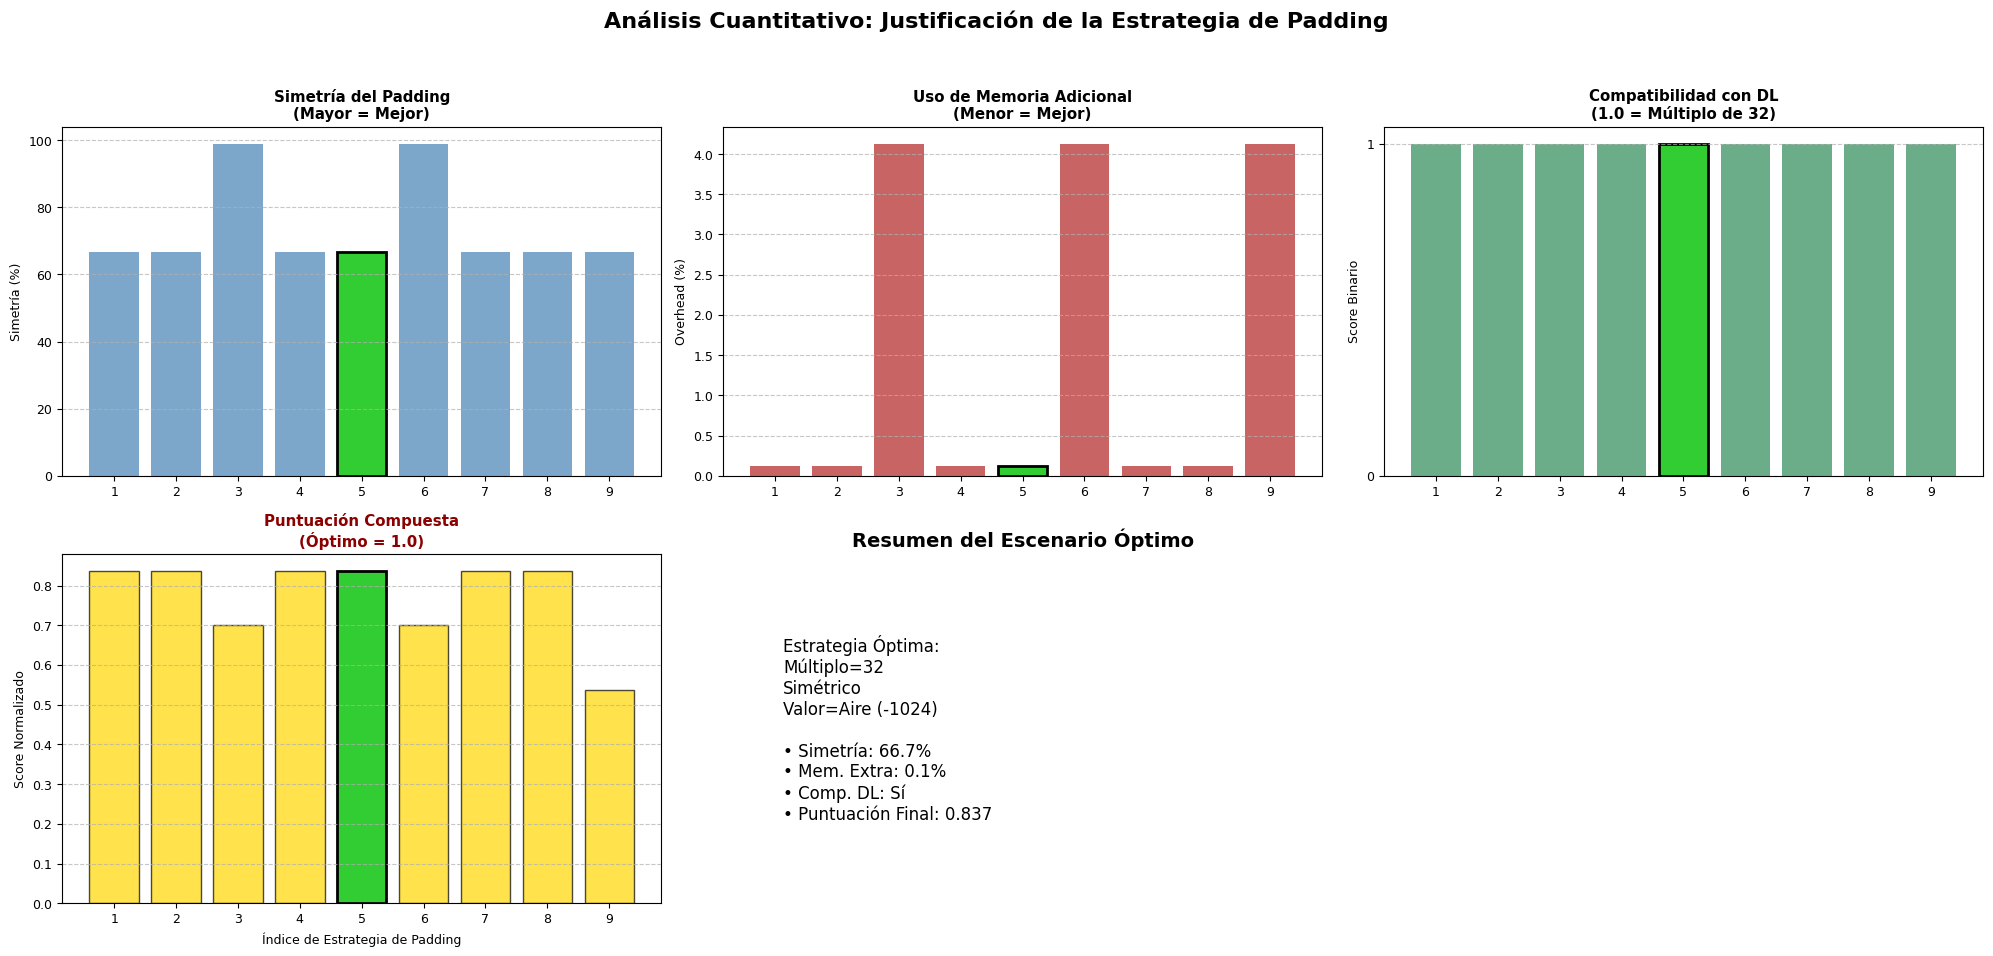

In [ ]:
# =========================
# Justificación Cuantitativa de la Estrategia de Padding
# Análisis comparativo de métricas que respaldan la elección del padding simétrico
# con múltiplo 32 y valor de aire (-1024). Incluye métricas de simetría, eficiencia
# de memoria y compatibilidad con Deep Learning.
# =========================

import numpy as np
import matplotlib.pyplot as plt

# === Función para calcular métricas primarias de padding ===
def calculate_padding_primary_metrics(multiple, mode, value):
    """
    Calcula las métricas fundamentales para evaluar una estrategia de padding.
    """
    # Aplicar el padding
    padded_vol, pad_width = apply_padding(vol_clipped, multiple, mode, value)
    
    # 1. Simetría del Padding (%)
    symmetry_scores = []
    for (before, after) in pad_width:
        if before + after == 0:
            symmetry_scores.append(1.0)
        else:
            symmetry = 1.0 - (abs(before - after) / (before + after))
            symmetry_scores.append(symmetry)
    avg_symmetry = np.mean(symmetry_scores) * 100
    
    # 2. Uso de Memoria Adicional (%)
    orig_size = np.prod(vol_clipped.shape)
    padded_size = np.prod(padded_vol.shape)
    memory_overhead = ((padded_size - orig_size) / orig_size) * 100
    
    # 3. Compatibilidad con Deep Learning (¿Es múltiplo de 32?)
    is_compatible = all(dim % 32 == 0 for dim in padded_vol.shape)
    
    return avg_symmetry, memory_overhead, is_compatible

# === Función auxiliar de padding (igual que en el mosaico) ===
def apply_padding(volume, multiple, mode, value):
    new_shape = []
    for dim in volume.shape:
        remainder = dim % multiple
        if remainder == 0:
            new_shape.append(dim)
        else:
            new_shape.append(dim + (multiple - remainder))
    
    if mode == 'constant':
        pad_width = []
        for i, dim in enumerate(volume.shape):
            total_pad = new_shape[i] - dim
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_width.append((pad_before, pad_after))
        padded = np.pad(volume, pad_width, mode=mode, constant_values=value)
    else: # 'edge' or asymmetric
        pad_width = []
        for i, dim in enumerate(volume.shape):
            total_pad = new_shape[i] - dim
            pad_width.append((0, total_pad))
        padded = np.pad(volume, pad_width, mode='constant', constant_values=value)
    
    return padded, pad_width

# === Preparar los datos y calcular métricas ===
test_scenarios = [
    (16, 'constant', 0), (32, 'constant', 0), (64, 'constant', 0),
    (16, 'constant', -1024), (32, 'constant', -1024), (64, 'constant', -1024),
    (16, 'edge', -1024), (32, 'edge', -1024), (64, 'edge', -1024),
]

# Calcular métricas para todos los escenarios
all_metrics = []
for multiple, mode, value in test_scenarios:
    metrics = calculate_padding_primary_metrics(multiple, mode, value)
    all_metrics.append(metrics)

# Desempaquetar las métricas
symmetries = [m[0] for m in all_metrics]
memory_overheads = [m[1] for m in all_metrics]
dl_compatibilities = [m[2] for m in all_metrics]

# === Calcular la Puntuación Compuesta (corregida) ===
# Normalizar las métricas para la puntuación compuesta
max_symmetry = max(symmetries)
min_memory = min(memory_overheads)

# Convertir compatibilidad DL a un score numérico (1.0 si es compatible, 0.2 si no)
dl_scores = [1.0 if compat else 0.2 for compat in dl_compatibilities]

composite_scores = []
for i in range(len(all_metrics)):
    sym, mem, _ = all_metrics[i]
    score = (
        0.5 * (sym / max_symmetry) +          # Simetría es muy importante
        0.3 * (1 - (mem - min_memory) / (max(memory_overheads) - min_memory + 1e-5)) + # Eficiencia de memoria
        0.2 * dl_scores[i]                    # Compatibilidad con DL es crucial
    )
    composite_scores.append(score)

# === Crear la figura de análisis comparativo ===
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Análisis Cuantitativo: Justificación de la Estrategia de Padding', 
             fontsize=16, weight='bold', y=0.98)

# Lista de todas las barras para destacar el escenario óptimo
all_bars = []

# --- Fila 1: Métricas Primarias ---
# Simetría del Padding
bars1 = axs[0, 0].bar(range(1, 10), symmetries, color='steelblue', alpha=0.7)
all_bars.append(bars1)
axs[0, 0].set_title('Simetría del Padding\n(Mayor = Mejor)', weight='bold')
axs[0, 0].set_ylabel('Simetría (%)')
axs[0, 0].set_xticks(range(1, 10))
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# Uso de Memoria Adicional
bars2 = axs[0, 1].bar(range(1, 10), memory_overheads, color='firebrick', alpha=0.7)
all_bars.append(bars2)
axs[0, 1].set_title('Uso de Memoria Adicional\n(Menor = Mejor)', weight='bold')
axs[0, 1].set_ylabel('Overhead (%)')
axs[0, 1].set_xticks(range(1, 10))
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

# Compatibilidad con Deep Learning
bars3 = axs[0, 2].bar(range(1, 10), dl_scores, color='seagreen', alpha=0.7)
all_bars.append(bars3)
axs[0, 2].set_title('Compatibilidad con DL\n(1.0 = Múltiplo de 32)', weight='bold')
axs[0, 2].set_ylabel('Score Binario')
axs[0, 2].set_xticks(range(1, 10))
axs[0, 2].set_yticks([0, 1])
axs[0, 2].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Fila 2: Métricas de Robustez y Síntesis ---
# Puntuación Compuesta (La más importante)
bars4 = axs[1, 0].bar(range(1, 10), composite_scores, color='gold', alpha=0.7, edgecolor='black')
all_bars.append(bars4)
axs[1, 0].set_title('Puntuación Compuesta\n(Óptimo = 1.0)', weight='bold', color='darkred')
axs[1, 0].set_ylabel('Score Normalizado')
axs[1, 0].set_xlabel('Índice de Estrategia de Padding')
axs[1, 0].set_xticks(range(1, 10))
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# Panel de Resumen: Tabla del Escenario Óptimo
optimal_idx = 4 # Índice de (32, 'constant', -1024)
opt_sym, opt_mem, opt_compat = all_metrics[optimal_idx]
opt_score = composite_scores[optimal_idx]
opt_multiple, opt_mode, opt_value = test_scenarios[optimal_idx]

summary_text = (
    f"Estrategia Óptima:\n"
    f"Múltiplo={opt_multiple}\n"
    f"Simétrico\n"
    f"Valor=Aire ({opt_value})\n\n"
    f"• Simetría: {opt_sym:.1f}%\n"
    f"• Mem. Extra: {opt_mem:.1f}%\n"
    f"• Comp. DL: {'Sí' if opt_compat else 'No'}\n"
    f"• Puntuación Final: {opt_score:.3f}"
)
axs[1, 1].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center', transform=axs[1, 1].transAxes)
axs[1, 1].set_title('Resumen del Escenario Óptimo', weight='bold', fontsize=14)
axs[1, 1].axis('off')

# Espacio vacío para mantener el layout 2x3
axs[1, 2].axis('off')

# === Destacar el escenario óptimo en todos los gráficos ===
OPTIMAL_BAR_INDEX = 4
OPTIMAL_COLOR = 'limegreen'
for bars in all_bars:
    bars[OPTIMAL_BAR_INDEX].set_color(OPTIMAL_COLOR)
    bars[OPTIMAL_BAR_INDEX].set_alpha(1.0)
    bars[OPTIMAL_BAR_INDEX].set_edgecolor('black')
    bars[OPTIMAL_BAR_INDEX].set_linewidth(2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()